In [1]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

2023-11-17 02:16:02.136075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "AbNormal"]

In [3]:
data = pd.read_csv("dataset/WISDM.csv")
data = data.drop('Unnamed: 0', axis=1)

sitting = data.loc[(data['activity'] == 'Sitting')]
jogging = data.loc[(data['activity'] == 'Jogging')]

df = pd.concat([sitting[:4499], jogging[:4500]])

df

,user-id,activity,timestamp,X,Y,Z
221333,27,Sitting,12363992261000,2.600000,9.660000,1.035146
221334,27,Sitting,12364042279000,2.680000,9.530000,0.503953
221335,27,Sitting,12364092267000,3.490000,8.890000,0.762740
221336,27,Sitting,12364142316000,3.640000,9.380000,0.926184
221337,27,Sitting,12364192273000,2.910000,9.340000,1.035146
...,...,...,...,...,...,...
13015,17,Jogging,58401032305000,5.434519,8.853226,3.909040
13016,17,Jogging,58401203050000,-4.331271,19.531578,-1.729784
13017,17,Jogging,58401432238000,-1.035146,-5.012288,-4.481094
13018,17,Jogging,58401542223000,7.082581,17.243360,-0.381370


In [4]:
df.shape

(8999, 6)

In [5]:
df.isnull().values.any()

False

Text(0.5, 0, 'activity')

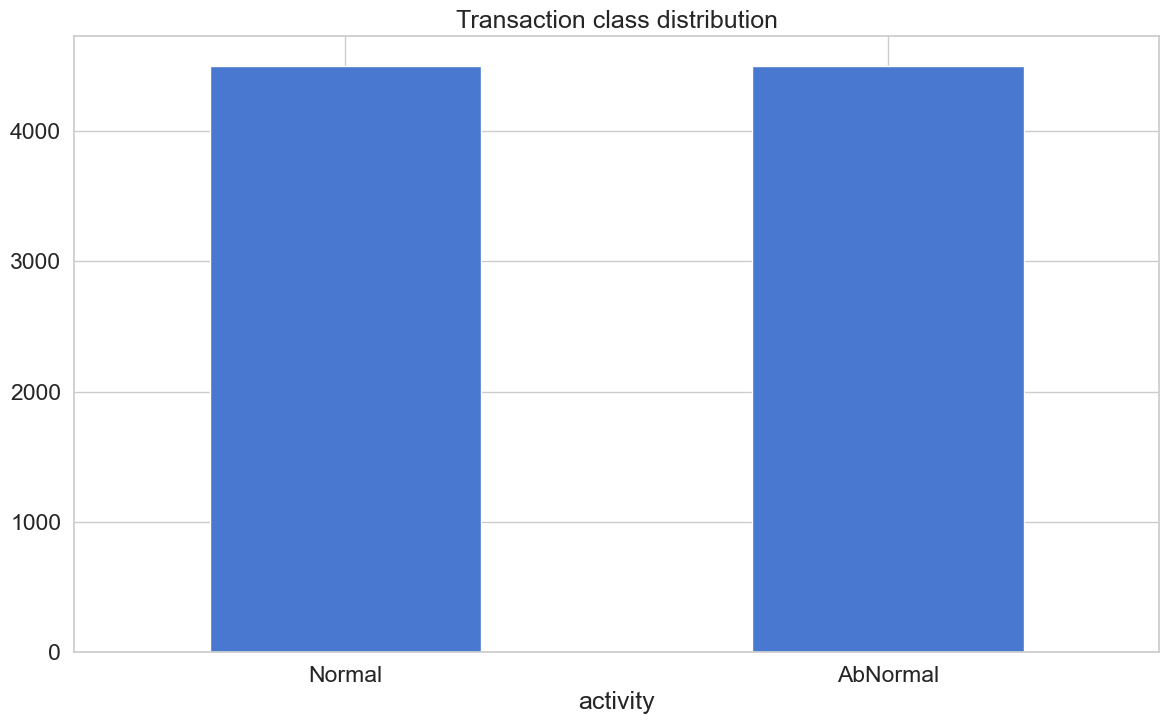

In [6]:
count_classes = pd.value_counts(df['activity'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("activity")

In [7]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'

df['X'] = df['X'] / df['X'].max()
df['Y'] = df['Y'] / df['Y'].max()
df['Z'] = df['Z'] / df['Z'].max()
# Round numbers
df = df.round({'X': 4, 'Y': 4, 'Z': 4})

In [8]:
abnormal = df[df.activity == 'Sitting']
normal = df[df.activity == 'Jogging']
abnormal.shape

(4499, 6)

In [9]:
normal.shape

(4500, 6)

In [10]:
# 모델을 오직 정상 거래기록으로만 훈련
# 정상 거래기록을 테스트셋에 넣으면 모델의 성능을 평가

In [11]:

X = df[['X', 'Y', 'Z']].values
y = df['activity'].apply(lambda x: 0 if x == 'Jogging' else 1).values  # Normal: 0, Abnormal: 1

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [13]:
X_train_noisy = X_train + 0.2 * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + 0.2 * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [14]:
input_dim = X_train.shape[1]

from keras.layers import GaussianNoise

input_layer = Input(shape=(input_dim,))
noise = GaussianNoise(0.2)(input_layer)  # 노이즈 추가
encoder = Dense(3, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(noise)
encoder = Dense(2, activation="relu")(encoder)
decoder = Dense(3, activation='tanh')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
predictions = autoencoder.predict(X_test_noisy)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)

threshold = np.mean(mse) + 2 * np.std(mse)
y_pred = [1 if e > threshold else 0 for e in mse]

57/57 [==============================] - 0s 1ms/step


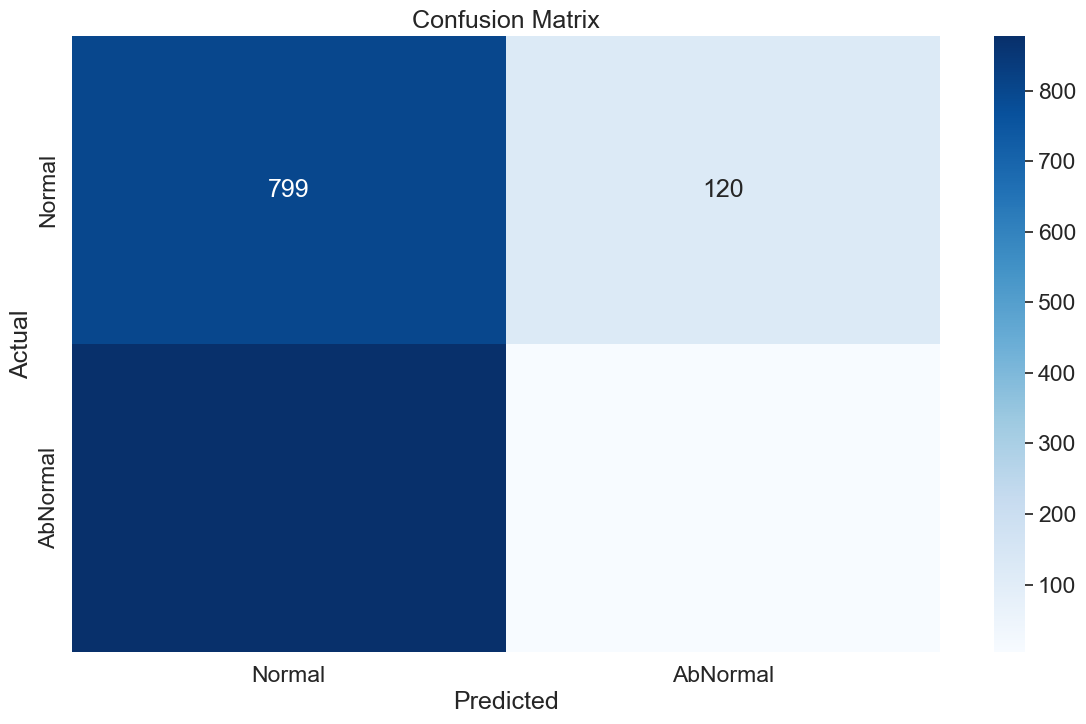

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()